# **1. Import Libaries**

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler 
from PIL import Image
import itertools
import warnings
warnings.filterwarnings('ignore')

2024-07-18 09:48:16.232423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 09:48:16.232613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 09:48:16.553324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **2. Load Data**

In [2]:
train_file = "/kaggle/input/digit-recognizer/train.csv"
test_file = "/kaggle/input/digit-recognizer/test.csv"
output_file = "/kaggle/input/digit-recognizer/sample_submission.csv"

In [3]:
#Train Data
import pandas as pd
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Test Data
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Check the data
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

# **3. Split Data**

In [6]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

# **4. Data Visualization**


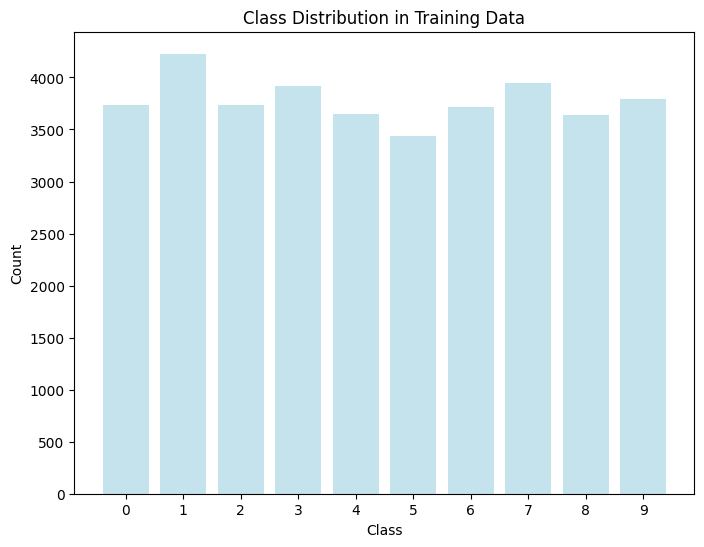

In [7]:
unique_classes, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, counts, color='lightblue', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_classes)
plt.show()


# **5. Preprocessing**

# **5.1. Reshape**

The reshaping of x_train and x_val into 28x28 grayscale images with an additional channel (reshape(-1, 28, 28, 1)) is necessary because Convolutional Neural Networks (CNNs) expect input data to be structured in this format. CNNs are designed to process image data with specific dimensions (height x width x channels), where:

* 28x28 specifies the dimensions of each image.
* 1 indicates that each image is grayscale, meaning it has a single color channel.

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print("train shape: ",x_train.shape)
print("validation shape: ",x_val.shape)

train shape:  (37800, 28, 28, 1)
validation shape:  (4200, 28, 28, 1)


# **5.2. Normalization**

Dividing x_train and x_val by 255 converts pixel values from a range of 0-255 to a scale of 0-1. This normalization step ensures that the neural network can effectively learn from the data, leading to better training performance.

In [9]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

# **5.3. Encoding labels**

Using to_categorical converts the label arrays y_train and y_val into categorical format. This transformation is crucial for training models that classify data into multiple classes. It encodes each label as a binary vector, where each position corresponds to a class, ensuring compatibility with neural networks designed for categorical classification tasks.

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# **6. Convolutional Neural Network (CNN)**

* **Input Layer:** Accepts input images of size 28x28 pixels with 1 channel (grayscale).

* **Convolutional Layers:** These layers extract features from the input images using convolution operations. Each Conv2D layer is followed by Batch Normalization to stabilize and accelerate the training process by normalizing the activations. ReLU activation function is used to introduce non-linearity.

* **Max Pooling Layers:** After each pair of convolutional layers, MaxPool2D layers downsample the feature maps, reducing their spatial dimensions and thereby reducing computation while preserving important features.

* **Dropout Layers:** Dropout is applied after convolutional and dense layers to prevent overfitting by randomly setting a fraction of input units to zero during training.

* **Flatten Layer:** Converts the 2D feature maps into a 1D feature vector, preparing the data for the dense layers.

* **(Fully Connected) Layers:** These layers perform classification on the features extracted by the convolutional layers. They are densely connected, meaning each neuron in a layer is connected to every neuron in the previous layer. ReLU activation is used in the dense layers to introduce non-linearity.

* **Output Layer:** The final layer has 10 neurons (corresponding to 10 classes) and uses softmax activation to output probabilities for each class, making it suitable for multi-class classification tasks.

**CNN Architecture**

<a href="https://ibb.co/d4bNkDM"><img src="https://i.ibb.co/jkVC3Df/cnn-1.jpg" alt="cnn-1" border="0" /></a>

In [11]:
from tensorflow.keras.layers import Input

model = Sequential()

model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# **6.1 Data Augmentation**

The ImageDataGenerator is set up to randomly zoom, shift vertically and horizontally, and rotate images slightly during training. This technique, called data augmentation, To prevent overfitting, we simulate real-world variations in handwritten digits by applying minor transformations.

In [12]:
datagen = ImageDataGenerator(
    zoom_range=0.1,              #zoom images
    height_shift_range=0.1,      #shift images vertically
    width_shift_range=0.1,       # shift images horizontally
    rotation_range=10            # rotate images within 10 degrees
)

# **6.2 Training**

**Compile the model:** prepares it for training by defining how it measures performance (using categorical crossentropy for multi-class classification), optimizes weights (with Adam optimizer), and evaluates accuracy during training.

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

This **LearningRateScheduler** gradually reduces the learning rate (1e-3) over epochs (x) by multiplying it with 0.9 ** x. It helps the model to stabilize and improve its performance as training progresses.

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [15]:
hist = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20,
                           verbose=2, 
                           validation_data=(x_val[:400,:], y_val[:400,:]),
                           callbacks=[annealer])

Epoch 1/20
500/500 - 15s - 31ms/step - accuracy: 0.7224 - loss: 0.8579 - val_accuracy: 0.9250 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 2/20
500/500 - 11s - 23ms/step - accuracy: 0.8993 - loss: 0.3386 - val_accuracy: 0.9700 - val_loss: 0.1106 - learning_rate: 9.0000e-04
Epoch 3/20
500/500 - 12s - 23ms/step - accuracy: 0.9209 - loss: 0.2610 - val_accuracy: 0.9600 - val_loss: 0.1091 - learning_rate: 8.1000e-04
Epoch 4/20
500/500 - 12s - 23ms/step - accuracy: 0.9339 - loss: 0.2133 - val_accuracy: 0.9725 - val_loss: 0.0763 - learning_rate: 7.2900e-04
Epoch 5/20
500/500 - 8s - 17ms/step - accuracy: 0.9471 - loss: 0.1891 - val_accuracy: 0.9675 - val_loss: 0.0955 - learning_rate: 6.5610e-04
Epoch 6/20
500/500 - 11s - 22ms/step - accuracy: 0.9519 - loss: 0.1616 - val_accuracy: 0.9925 - val_loss: 0.0319 - learning_rate: 5.9049e-04
Epoch 7/20
500/500 - 11s - 22ms/step - accuracy: 0.9524 - loss: 0.1573 - val_accuracy: 0.9725 - val_loss: 0.0770 - learning_rate: 5.3144e-04
Epoch 8/20
500/500

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0230, final accuracy: 0.9931


# **6.3 Evaluate The Model**

* Loss Plot
* Accuaracy Plot 
* Confusion Matrix

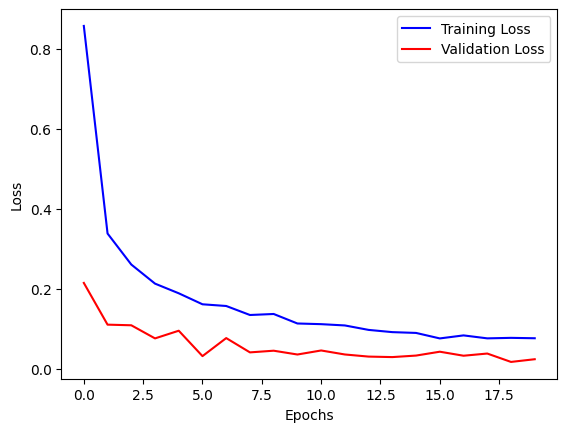

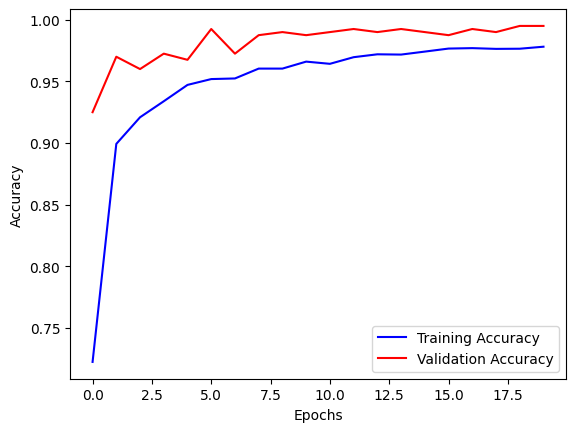

In [17]:
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion Matrix: [[394   0   0   0   0   0   0   0   1   0]
 [  0 453   1   0   1   0   0   1   0   0]
 [  0   0 439   3   0   0   0   2   0   0]
 [  0   0   0 432   0   1   0   0   0   0]
 [  0   0   0   0 421   0   0   0   0   2]
 [  0   0   0   2   0 354   1   0   2   1]
 [  0   0   0   0   0   0 419   0   0   0]
 [  0   0   0   0   1   0   0 450   0   0]
 [  0   0   0   0   1   1   0   0 417   2]
 [  1   0   0   0   3   0   0   0   2 392]]


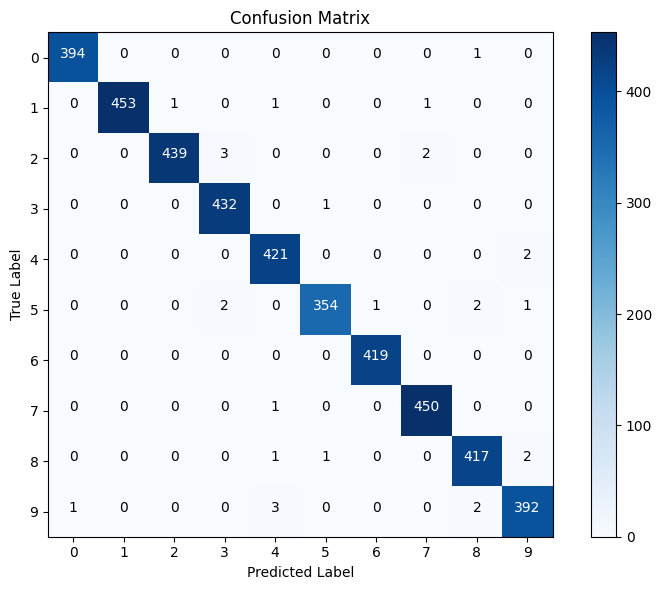

In [18]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:", cm)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Labeling the plot
num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# **6.4 Test The Model**

* Testing with Test Data
* Testing with External Images

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


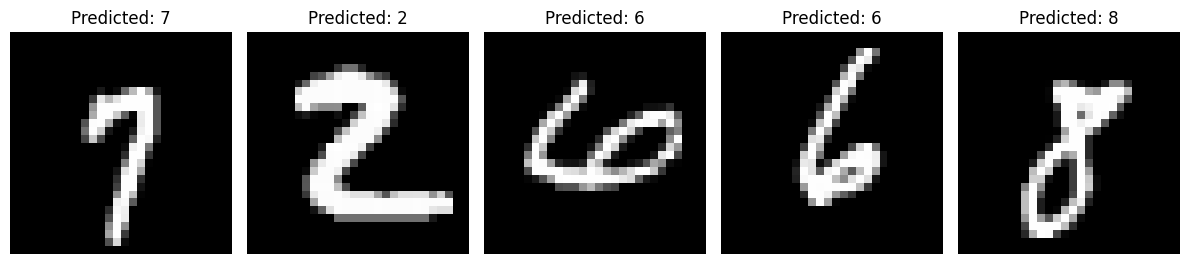

In [19]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Convert to numpy array and reshape
x_test = test_data.values.reshape(-1, 28, 28, 1).astype("float32") / 255.

# Make predictions
predictions = model.predict(x_test)
 
predicted_classes = np.argmax(predictions, axis=1)
random_indices = random.sample(range(len(x_test)), 5)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_classes[idx]}') 
    plt.axis('off')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


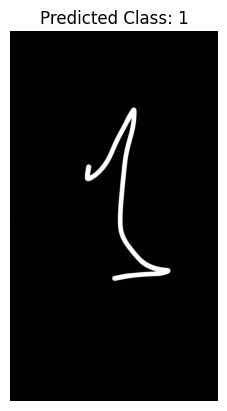

In [20]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((28, 28))  
    img = img.convert('L') 
    img_array = np.array(img).reshape(1, 28, 28, 1).astype('float32') / 255.
    return img_array

def classify_image(image_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        return
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/kaggle/input/testing-model/WhatsApp Image 2024-07-18 at 10.52.00 AM.jpeg' 
classify_image(image_path)


# **7. Submit**


In [21]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
x_test = test_data.values.reshape(-1, 28, 28, 1).astype("float32") / 255.
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Create submission DataFrame
submission = pd.DataFrame({
    'ImageId': range(1, len(predicted_classes) + 1),
    'Label': predicted_classes
})

submission.to_csv('submission.csv', index=False)
print("Submission file created.")

875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Submission file created.
